## 1D marginals for $(\zeta, T_{\rm vir}^{\rm min}, R_{\rm mfp}, L_{X}, E_0, \alpha)$: Redshift dependence

Copy the store to the local gpu node

In [1]:
%%time
!cp -r /data/p303146/Projects/Inference21cm/Astro_6/fixSeed/s21cm_Astro_6.zarr* /local/tmp/

CPU times: user 3.54 s, sys: 1.19 s, total: 4.73 s
Wall time: 3min 54s


---
Importing dependencies

In [2]:
import numpy as np
import scipy
import pickle

import torch
import swyft.lightning as sl

import seaborn as sns
sns.set_theme(style="whitegrid", font="STIXgeneral")

import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
plt.rcParams["mathtext.fontset"] = "stix"
%config InlineBackend.figure_format = "svg"
%matplotlib inline

In [3]:
# Redshifts
reds_EoH = [24.359810, 20.219959, 17.111031, 14.457590, 12.456770]
reds_EoR = [10.714930, 9.402521, 8.237142, 7.202319, 6.429094]
reds = reds_EoH + reds_EoR

# Parameters: zeta, Tvir, Rmfp, Lx, E0, \alpha
labels = [r'$\zeta$', r'$T_{\rm vir}^{\rm min}$', r'$R_{\rm mfp}$',
          r'$L_X$', r'$E_0$', r'$\alpha_{X}$']

# True values of the parameters
vtrue = np.array([30, 4.69897, 15, 40.5, 500, 1])

# Priors
vmin = np.array([10, 4.2, 8, 39.5, 100, -0.5])
vmax = np.array([100, 5.4, 25, 41.5, 900, 2.5])

# Path for mock observation and noise
noisePath = "./ska_low_noise.npy"
obsPath = "./mockObs.pkl"

---
Mock Observation

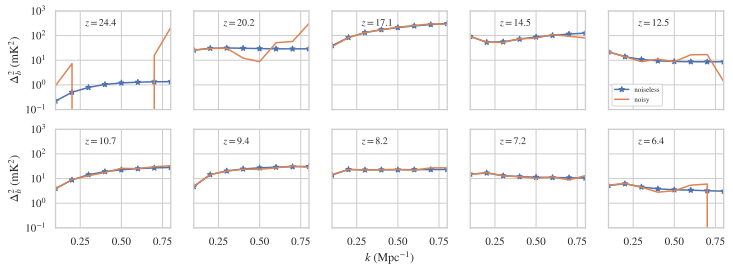

In [5]:
with open(obsPath, 'rb') as f:
    obs0 = pickle.load(f)

fig, ax = plt.subplots(2, 5, figsize=(12, 4), sharex=True, sharey=True)
k_vals = np.linspace(0.1, 0.8, 8)
for i, ax in enumerate(fig.axes):
    ax.plot(k_vals, obs0['pk_mu_z%.1f'%reds[i]], "*-", label="noiseless")
    ax.plot(k_vals, obs0['pk_z%.1f'%reds[i]], label="noisy")
    ax.set_ylim(1e-1, 1e3)
    ax.set_xlim(k_vals[0], k_vals[-1])
    ax.set_yscale("log")
    if i == 4: ax.legend(loc="lower left", fontsize=7)
    if i == 7: ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    if i == 0 or i == 5: ax.set_ylabel(r"$\Delta_{b}^2$ (mK$^2$)")
    ax.text(0.28, 2.5*1e2, r"$z=%.1f$"%reds[i], fontsize=10)

---
Instrumental noise from ska-low to be used in hook

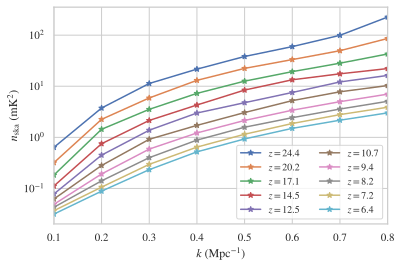

In [6]:
# Instrumental noise level from SKA low: sim using ps_eor
instNoise = np.load(noisePath)

fig, ax = plt.subplots()
for i in range(len(reds)):
    ax.plot(k_vals, instNoise[i], "*-", label=r"$z = %.1f$"%reds[i])
    ax.set_yscale("log")
    ax.set_xlim(k_vals[0], k_vals[-1])
    ax.legend(ncol=2, fontsize=10)
    ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    ax.set_ylabel(r"$n_{\rm ska}$ (mK$^2$)")

# Use it as a hook: includes the instrumental noise and sample variance
def noise(out):
    for i in range(len(reds)):
        mu = out['pk_mu_z%.1f'%reds[i]]
        sv = out['pk_sv_z%.1f'%reds[i]]
        
        # Total noise including the intrumental noise and sample variance
        total_noise_val = np.sqrt(instNoise[i]**2. + sv**2.)
        n = np.float32(np.random.randn(*total_noise_val.shape))*total_noise_val
        
        out['pk_z%.1f'%reds[i]] = mu + n
    return out

---
ZarrStore

In [7]:
zs = sl.ZarrStore("/local/tmp/s21cm_Astro_6.zarr")
data_loader_train = zs.get_dataloader(num_workers=12, batch_size=64, idx_range=[0, 16_000], hook=noise)
data_loader_val = zs.get_dataloader(num_workers=12, batch_size=64, idx_range=[16_000, 20_000], hook=noise)

---
**EoH trainer, network**

---
Trainer

In [8]:
trainer_1D_EoH = sl.SwyftTrainer(accelerator='gpu', gpus=1, max_epochs=100,
                                 **sl.tensorboard_config(name = 'post1D_EoH', version=None))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


---
Network architecture

In [9]:
class Network_1D_EoH(sl.SwyftModule):
    def __init__(self):
        super().__init__(lr=1e-4)
        
        self.n_features = 16
        self.l = torch.nn.Linear(40, 16)
        self.classifier = sl.RatioEstimatorMLP1d(self.n_features, len(vtrue), hidden_features=256,
                                                 num_blocks=2, dropout=0.1)       
        
    def forward(self, A, B):
        x = torch.cat([A['pk_z%.1f'%zi] for zi in reds_EoH], axis=1)
        x = self.l(x)
        z = B['z']
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [10]:
network_1D_EoH = Network_1D_EoH()

---
Training the network

In [11]:
%%time
trainer_1D_EoH.fit(network_1D_EoH, data_loader_train, data_loader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type                | Params
---------------------------------------------------
0 | l          | Linear              | 656   
1 | classifier | RatioEstimatorMLP1d | 1.6 M 
---------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.485     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/data/p303146/.envs/lightning/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 2min 31s, sys: 55.5 s, total: 3min 27s
Wall time: 3min 57s


---
Predictions from the trained network

In [12]:
# If you want to make predictions for a noiseless observation, then use 'pk_mu_z' key instead.
pd_1D_EoH = trainer_1D_EoH.infer(network_1D_EoH, data_loader_train,
                         conditions={'pk_z%.1f'%zi: obs0['pk_z%.1f'%zi] for zi in reds_EoH})

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 250it [00:00, ?it/s]

/data/p303146/.envs/lightning/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Samples

In [13]:
post_samples_1D_EoH = pd_1D_EoH.sample(1_000_000)
samples_1D_EoH = post_samples_1D_EoH['z'].numpy()

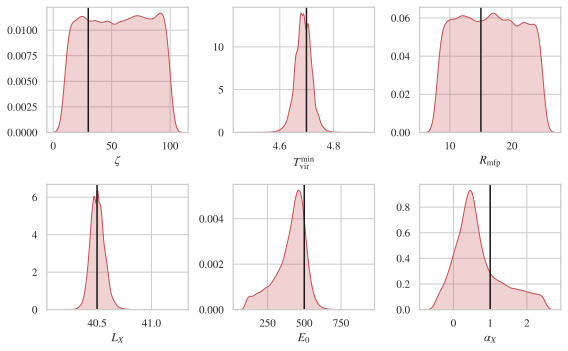

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
cn = 0
for i in range(2):
    for j in range(3):
        sns.kdeplot(ax=axes[i, j], data=samples_1D_EoH[:, cn], color="r", bw_adjust=2, fill=True)
        axes[i, j].axvline(vtrue[cn], color='k')
        axes[i, j].set_xlabel("%s"%labels[cn])
        axes[i, j].set_ylabel("")
        cn += 1
plt.tight_layout()
plt.show()

---
**EoR: Network, Trainer**

In [15]:
trainer_1D_EoR = sl.SwyftTrainer(accelerator='gpu', gpus=1, max_epochs=100,
                                 **sl.tensorboard_config(name = 'post1D_EoR', version=None))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [16]:
class Network_1D_EoR(sl.SwyftModule):
    def __init__(self):
        super().__init__(lr=1e-4)
        
        self.n_features = 16
        self.l = torch.nn.Linear(40, 16)
        self.classifier = sl.RatioEstimatorMLP1d(self.n_features, len(vtrue), hidden_features=256,
                                                 num_blocks=2, dropout=0.1)       
        
    def forward(self, A, B):
        x = torch.cat([A['pk_z%.1f'%zi] for zi in reds_EoR], axis=1)
        x = self.l(x)
        z = B['z']
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [17]:
network_1D_EoR = Network_1D_EoR()

In [18]:
%%time
trainer_1D_EoR.fit(network_1D_EoR, data_loader_train, data_loader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type                | Params
---------------------------------------------------
0 | l          | Linear              | 656   
1 | classifier | RatioEstimatorMLP1d | 1.6 M 
---------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.485     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/data/p303146/.envs/lightning/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 1min 15s, sys: 26.8 s, total: 1min 42s
Wall time: 1min 52s


In [19]:
# If you want to make predictions for a noiseless observation, then use 'pk_mu_z' key instead.
pd_1D_EoR = trainer_1D_EoR.infer(network_1D_EoR, data_loader_train,
                         conditions={'pk_z%.1f'%zi: obs0['pk_z%.1f'%zi] for zi in reds_EoR})

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 250it [00:00, ?it/s]

In [20]:
post_samples_1D_EoR = pd_1D_EoR.sample(1_000_000)
samples_1D_EoR = post_samples_1D_EoR['z'].numpy()

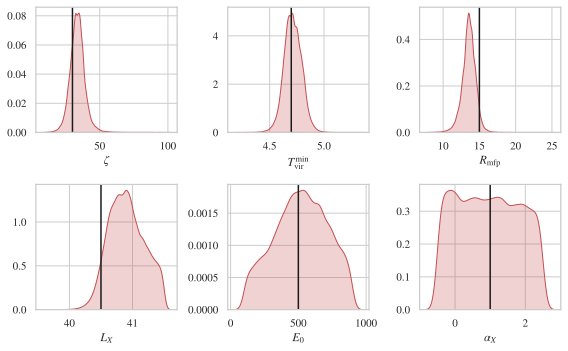

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
cn = 0
for i in range(2):
    for j in range(3):
        sns.kdeplot(ax=axes[i, j], data=samples_1D_EoR[:, cn], color="r", bw_adjust=2, fill=True)
        axes[i, j].axvline(vtrue[cn], color='k')
        axes[i, j].set_xlabel("%s"%labels[cn])
        axes[i, j].set_ylabel("")
        cn += 1
plt.tight_layout()
plt.show()

---
#### Comparing the EoH and EoR posteriors

In [49]:
reds_EoH_string =  ", ".join(str(i) for i in ("%.2f"%j for j in reds_EoH))
reds_EoR_string =  ", ".join(str(i) for i in ("%.2f"%j for j in reds_EoR))

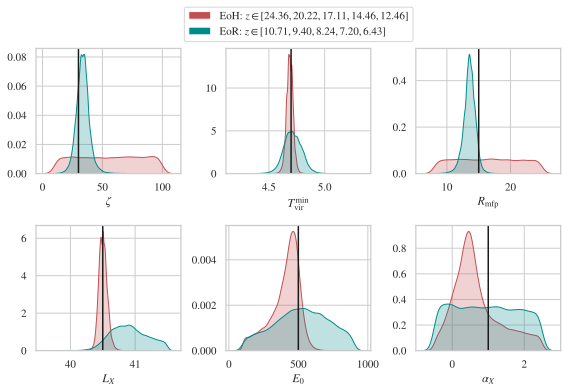

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
cn = 0
for i in range(2):
    for j in range(3):
        sns.kdeplot(ax=axes[i, j], data=samples_1D_EoH[:, cn], color="r", bw_adjust=2, fill=True)
        sns.kdeplot(ax=axes[i, j], data=samples_1D_EoR[:, cn], color="darkcyan", bw_adjust=2, fill=True)
        axes[i, j].axvline(vtrue[cn], color='k')
        axes[i, j].set_xlabel("%s"%labels[cn])
        axes[i, j].set_ylabel("")
        cn += 1

handles = [mpatches.Patch(facecolor="r", label=r"EoH: $z \in [%s]$"%reds_EoH_string),
           mpatches.Patch(facecolor="darkcyan", label="EoR: $z \in [%s]$"%reds_EoR_string)]
fig.legend(handles=handles, bbox_to_anchor=(0.734, 1.1))
plt.tight_layout()
plt.show()